In [4]:
import pystan
import pandas as pd
import os
import re
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder


from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Data**

20 students taking CS146 during the Spring 2020 semester compiled the dataset below by gathering prices for 10 products in two different grocery stores, across different cities and neighborhoods. The products researched, and their base quantities, were: apples (kg), bananas (kg), tomatoes (kg), potatoes (kg), white flour (kg), basmati rice (kg), full cream milk (l), butter (kg), eggs (unit), and chicken breast (kg).

14 students were located in Buenos Aires, 5 were in Taipei and 1 was in San Francisco. Because we only had one student in San Francisco, who went to one supermarket chain in two neighborhoods, the confidence for prices in the city is relatively low, compared to the others, where at least 10 different supermarkets were visited. Thus, I choose to remove San Francisco from the dataset. For currency consistency, all prices were given in Argentine pesos, using a conversion rate of $NT\$ 1 = ARS\$ 2$.

Finally, as we don't have enough information to properly differentiate prices between neighborhoods in Taipei, I treat Taipei as a neighborhood of Buenos Aires in the model.

In [5]:
'''
Data pre-processed in Excel:
Normalized data;
Manually fixed data entry errors (one unit was 1857 liters, rather than 1.857; another entry had unit and price switched);
Cleaning data to run the model.
'''

# Loading the data
data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/CS146 LBA.csv")
data.head(10)

# Keeping only normalized columns
df = data[['Store', 'Neighborhood','Apple 1 Price (ARS/kg)', 'Apple 2 Price (ARS/kg)', 'Apple 3 Price (ARS/kg)', 'Banana 1 Price (ARS/kg)', 'Banana 2 Price (ARS/kg)', 'Banana 3 Price (ARS/kg)', 'Tomato 1 Price (ARS/kg)', 'Tomato 2 Price (ARS/kg)', 'Tomato 3 Price (ARS/kg)', 'Potato 1 Price (ARS/kg)', 'Potato 2 Price (ARS/kg)', 'Potato 3 Price (ARS/kg)', 'Flour 1 Price (ARS/kg)', 'Flour 2 Price (ARS/kg)', 'Flour 3 Price (ARS/kg)', 'Rice 1 Price (ARS/kg)', 'Rice 2 Price (ARS/kg)', 'Rice 3 Price (ARS/kg)', 'Milk 1 Price (ARS/l)', 'Milk 2 Price (ARS/l)', 'Milk 3 Price (ARS/l)', 'Eggs 1 Price (ARS/egg)', 'Eggs 2 Price (ARS/egg)', 'Eggs 3 Price (ARS/egg)', 'Butter 1 Price (ARS/kg)', 'Butter 2 Price (ARS/kg)', 'Butter 3 Price (ARS/kg)', 'Chicken Breast 1 Price (ARS/kg)', 'Chicken Breast 2 Price (ARS/kg)', 'Chicken Breast 3 Price (ARS/kg)']]
df.head(10)

# Reshaping the data from wide to long format
df = pd.melt(df, id_vars=['Store', 'Neighborhood'], value_vars=['Apple 1 Price (ARS/kg)', 'Apple 2 Price (ARS/kg)', 'Apple 3 Price (ARS/kg)', 'Banana 1 Price (ARS/kg)', 'Banana 2 Price (ARS/kg)', 'Banana 3 Price (ARS/kg)', 'Tomato 1 Price (ARS/kg)', 'Tomato 2 Price (ARS/kg)', 'Tomato 3 Price (ARS/kg)', 'Potato 1 Price (ARS/kg)', 'Potato 2 Price (ARS/kg)', 'Potato 3 Price (ARS/kg)', 'Flour 1 Price (ARS/kg)', 'Flour 2 Price (ARS/kg)', 'Flour 3 Price (ARS/kg)', 'Rice 1 Price (ARS/kg)', 'Rice 2 Price (ARS/kg)', 'Rice 3 Price (ARS/kg)', 'Milk 1 Price (ARS/l)', 'Milk 2 Price (ARS/l)', 'Milk 3 Price (ARS/l)', 'Eggs 1 Price (ARS/egg)', 'Eggs 2 Price (ARS/egg)', 'Eggs 3 Price (ARS/egg)', 'Butter 1 Price (ARS/kg)', 'Butter 2 Price (ARS/kg)', 'Butter 3 Price (ARS/kg)', 'Chicken Breast 1 Price (ARS/kg)', 'Chicken Breast 2 Price (ARS/kg)', 'Chicken Breast 3 Price (ARS/kg)'])

# Renaming columns and only keeping the general product category (apple, banana, etc)
df.rename(columns={'variable': 'Product','value': 'Price (ARS)'}, inplace=True)
df["Product"] = df["Product"].replace("\s.*","", regex=True)
df.head(10)

# Dealing with NAs
NA = pd.isna(df['Price (ARS)']).sum()
print('Number of missing observations is:', NA) # 296 missing values

df_clean = df.dropna().reset_index(drop=True)

# Dropping SF supermarkets, since we can't compare them properly as we only have 2 observations in SF
df_clean = df_clean[df_clean.Neighborhood != 'San Francisco']
print(df_clean)

print('Number of observations in final dataset:', len(df_clean))

Number of missing observations is: 296
                 Store Neighborhood  Product  Price (ARS)
0            Carrefour    Balvanera    Apple    50.000000
1            Carrefour    Balvanera    Apple    84.000000
2            Carrefour      Palermo    Apple    60.000000
3            Carrefour      Palermo    Apple   120.000000
4            Carrefour      Palermo    Apple    69.900000
..                 ...          ...      ...          ...
899  Supermercados Día      Palermo  Chicken   285.000000
900  Supermercados Día     Recoleta  Chicken   427.364865
901           Wellcome       Taipei  Chicken   500.000000
902           Wellcome       Taipei  Chicken   463.333333
903           Wellcome       Taipei  Chicken  1187.500000

[853 rows x 4 columns]
Number of observations in final dataset: 853


After deleting 296 observations with missing prices, we have a final dataset with 853 rows and 4 columns, with prices for 10 products across 4 different supermarket chains in 9 neighborhoods.




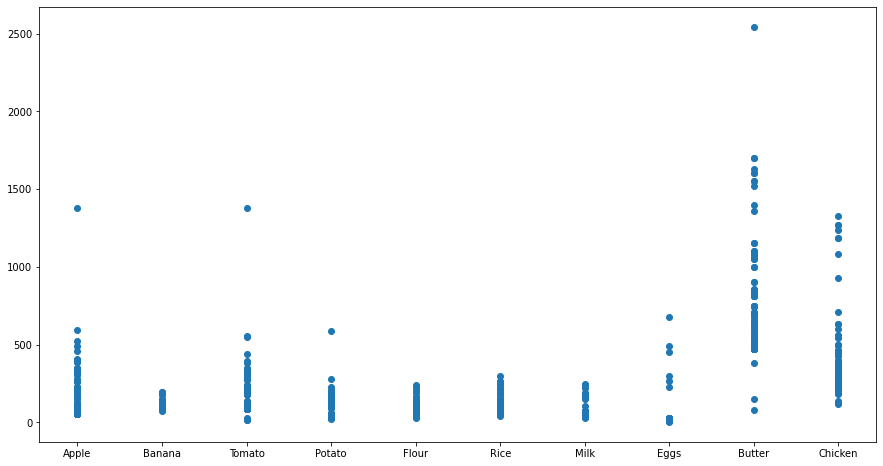

Product
Apple      177.866186
Banana     109.411658
Butter     771.299954
Chicken    440.494481
Eggs        35.327162
Flour       75.668278
Milk        92.438552
Potato      98.843714
Rice        95.141795
Tomato     186.568914
Name: Price (ARS), dtype: float64


In [6]:
for col in ['Store', 'Neighborhood', 'Product']:
    df_clean[col] = df_clean[col].astype('category')

product = df_clean['Product']
price = df_clean['Price (ARS)']
store = df_clean['Store']
neighborhood = df_clean['Neighborhood']

# Product descriptive statistics
plt.figure(figsize=(15,8))
plt.scatter(product,price)
plt.show()

print(price.groupby(product).mean())

From the means above, we can see that a single egg is the cheapest product to buy, and that a kilogram of butter is the most expensive. With the same amount of money one can purchase one kg of butter or almost 22 eggs. Comparing solely products measured in kg, the kilo of flour is the cheapest, with 1kg of butter = 10kg of flour.

However, we can see that the average price of butter is skewed by an outlier, which could be a data-entry mistake or an expensive brand of butter. Given that there are also outliers in potato, tomato, and apple, I assume this is the true price and, thus, keep the observation in the model.

It is interesting to observe that the price of bananas, flour, rice and milk seems to be relatively constant across all supermarkets and cities. Given that they are staple products that can be found easily in Taiwan as well as Argentina, this is not surprising. On the other hand, the kilogram of chicken breast seems to be concentrated around two main price ranges. This could denote supermarket chains selling chicken at different prices, or availability (and consequently, price) of chicken in Buenos Aires compared to Taiwan.

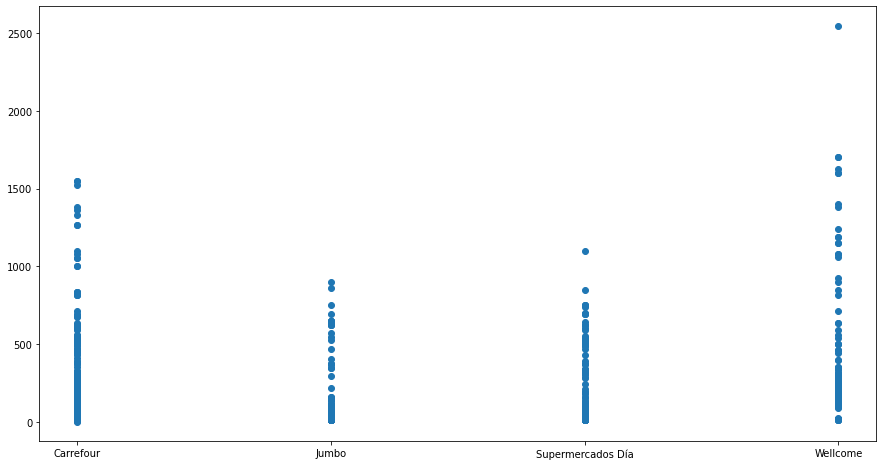

Store
Carrefour            220.373586
Jumbo                155.196000
Supermercados Día    149.370808
Wellcome             391.154016
Name: Price (ARS), dtype: float64


In [7]:
# Store descriptive statistics
plt.figure(figsize=(15,8))
plt.scatter(store,price)
plt.show()

print(price.groupby(store).mean())

From the descriptive statistics above, it seems that Supermercados Día has the lowest mean overall price, and Wellcome the highest – more than twice that of Sueprmercados Día. There also seems to be a certain amount of variability when we compare the four supermarkets, with Wellcome and Carrefour having a greater range in prices than Supermercados Día and Jumbo.

A potential explanation for this is that Wellcome and Carrefour are both present in Taipei, whereas Supermercados Día and Jumbo are not. We would expect the difference in prices between Taipei and Buenos Aires neighborhoods to be greater than within Buenos Aires neighborhoods, which could explain why the first two grocery stores have higher prices.

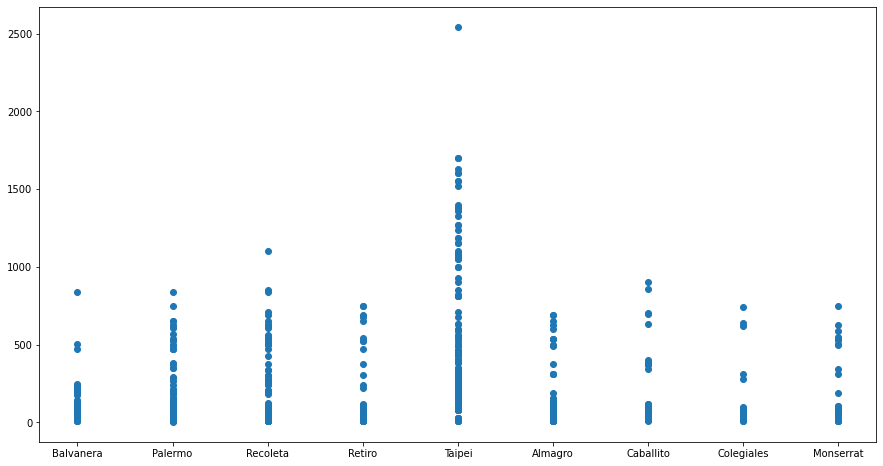

Neighborhood
Almagro       143.208889
Balvanera     142.198990
Caballito     157.958148
Colegiales    161.551515
Monserrat     144.862594
Palermo       140.514928
Recoleta      157.040513
Retiro        153.995917
Taipei        370.277915
Name: Price (ARS), dtype: float64


In [8]:
# Neighborhood descriptive statistics
plt.figure(figsize=(15,8))
plt.scatter(neighborhood,price)
plt.show()

print(price.groupby(neighborhood).mean())

Comparing the price ranges of Taipei and Buenos Aires neighborhoods points to the previous hypotheses regarding supermarket and product pricing. In general, food prices in Taipei vary a lot more than in Buenos Aires, where prices are concentrated on the cheaper end of the spectrum, even when disconsidering the fancy butter from Wellcome (priced at over AR$2500/kg).

Within Buenos Aires itself, Colegiales is the most expensive neighborhood to buy groceries in. According to Wikipedia, Colegiales is a "sought-after, family-friendly residential area near (...) dining and nightlife scene," which can explain why groceries are more expensive. This, however, could also be due to the fact that there are less datapoints for Colegiales than the other neighborhoods. 

It could also simply be due to chance. The cheapest, on average, neighborhood to shop for groceries is Palermo, a sprawling, trendy area full of nice "restaurants, chic cocktail haunts and quirky fashion stores." An interesting fact is that it is right next to Colegiales, which might not make much sense. The second cheapest, however, is Balvanera, a busy central area in the city. 

In [0]:
'''
Encoding the data
Shifting index so they do not start with 0 
'''
df_final = df_clean.copy()
encoder = OrdinalEncoder()
encoded_values=encoder.fit_transform(df_final[['Store','Neighborhood','Product','Price (ARS)']])

new_encoded_values = encoded_values.copy().astype(int)
df_id = new_encoded_values + 1

# Product = [Apple, Banana, Chicken, Eggs, Rice, Butter, Milk, Flour, Tomato, Potato]
# Store = [Carrefour, Jumbo, Supermercados Día, Wellcome]
# Neighborhood = [Almagro, Balvanera, Caballito, Colegiales, Monserrat, Palermo, Recoleta, Retiro, Taipei]

# **Model**
In this assignment, we try to estimate the base product prices and multipliers for store and neighborhood. 

## Likelihood
I begin by choosing a likelihood function that best models the data. The observed price is a product of the base price (a positive real number), the store multiplier (a positive real number centered around 1), and the neighborhood multiplier (a positive real number centered around 1). It makes sense, then, to assume that the prices are normally distributed according to:

${price} \sim \text{Normal}({\mu}, {\sigma^2})$

where ${mu} = base*store*neighborhood$, and ${\sigma^2}=$ an error term. 

## Prior distributions

### **Base Prices**
Our base prices can be modeled by a Cauchy prior. We know the base price should be a positive real number, but we don't know the scale, so we need to use a broad prior over the base price of each product. We would expect the base prices to be somewhat normally distributed, but the Cauchy distribution has heavier tails than the normal distribution, and thus is more useful in this case because it gives us broad priors. Using $USD\$ 1 = ARS\$ 63$, we can model our base price prior as: 

${Base} \sim \text{Cauchy}({315}, {126})$

This assume the average base price is around 6 USD, with a scale of 2.

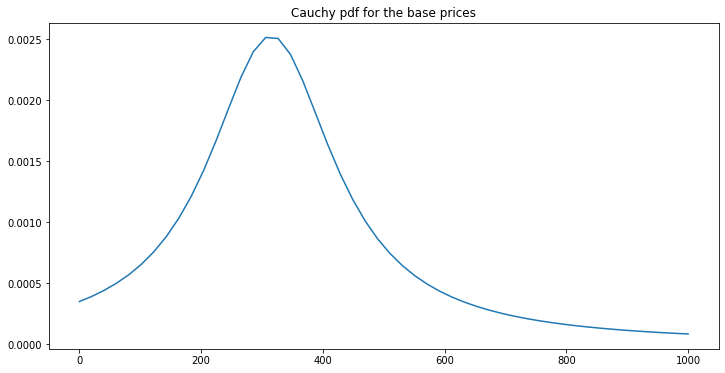

In [8]:
# Cauchy prior
base_prior = sts.cauchy(315, 126)
plt.figure(figsize=(12, 6))
x = np.linspace(0, 1000)
plt.plot(x, base_prior.pdf(x))
plt.title("Cauchy pdf for the base prices")
plt.show()

### **Multipliers**
The Store and Neighborhood multipliers can be modeled by a Gamma prior. This is because we expect multipliers to be strictly positive values that center around 1, for an average multiplier of 1. Stores and neighborhoods that are less expensive will have a multiplier smaller than 1, while those that are more expensive will have a multiplier greater than 1. The multiplier priors are given as:

${StoreMultiplier} \sim \text{Gamma}({2}, {1})$

${NeighborhoodMultiplier} \sim \text{Gamma}({2}, {1})$

The product of the three previous variables will give us $\mu$, the observed prices. 

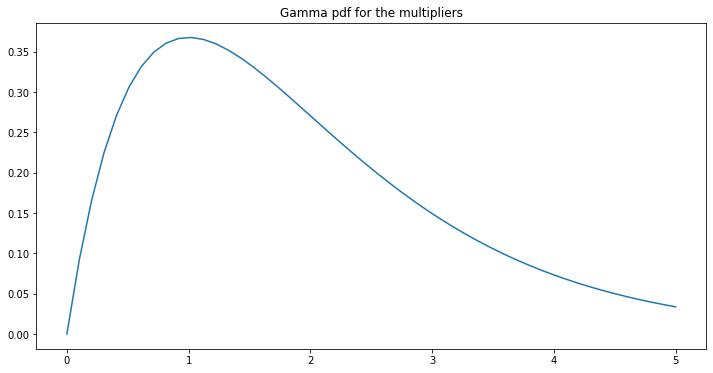

In [9]:
# Gamma prior
multiplier_prior = sts.gamma(2, scale = 1)
plt.figure(figsize=(12, 6))
x = np.linspace(0, 5)
plt.plot(x, multiplier_prior.pdf(x))
plt.title("Gamma pdf for the multipliers")
plt.show()

Finally, $\sigma^2$, is the variance for the Normal likelihood. It can be modeled by an inverse-gamma distribution, which is often used as a non-informative conjugate prior for $\sigma^2$.

${Variance} \sim \text{Inverse-gamma}({0.01}, {1})$


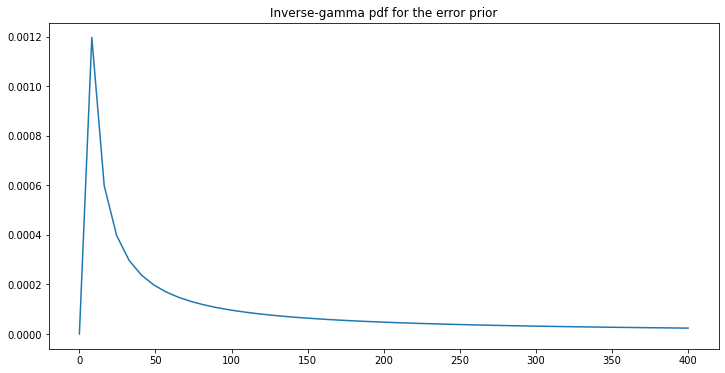

In [10]:
# Inverse-Gamma prior
error_prior = sts.invgamma(0.01, 1)
plt.figure(figsize=(12, 6))
x = np.linspace(0, 400)
plt.plot(x, error_prior.pdf(x))
plt.title("Inverse-gamma pdf for the error prior")
plt.show()

In [10]:
# Stan code for the model
stan_code = """

data {
    int<lower=0> N_products;    //number of product categories
    int<lower=0> N_stores;    //number of grocery store chains
    int<lower=0> N_neighborhoods;    //number of neighborhoods
    int<lower=0> N_data; // number of data points
    
    int<lower=1> id_products[N_data];    // id for each product type
    int<lower=1> id_stores[N_data];     // id for each store
    int<lower=1> id_neighborhoods[N_data]; // id for each neighborhood
    real<lower=0> prices[N_data];        // price for each product
    
}

parameters {
    real<lower=0> base_price[N_products];                    // base price of the product
    real<lower=0> store_multiplier[N_stores];          // grocery store multiplier
    real<lower=0> neighborhood_multiplier[N_neighborhoods];  // neighborhood multiplier
    real<lower=0> error_term;                                // standard deviation of the normal likelihood
}

model {
    base_price ~ cauchy(315, 126); // prior
    store_multiplier ~ gamma(2, 1);  // prior
    neighborhood_multiplier ~ gamma(2, 1); // prior
    error_term ~ inv_gamma(0.01,1); // prior
    
    for (i in 1:N_data) {
      prices[i] ~ normal(base_price[id_products[i]] * store_multiplier[id_stores[i]] * neighborhood_multiplier[id_neighborhoods[i]], error_term);
      }
}

"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_15a5a7e5df4b36b6a3674220c90d68f0 NOW.


In [0]:
# Data dictionary

stan_data = {
    'N_products': len(df_final['Product'].unique()), # number of product categories
    'N_stores': len(df_final['Store'].unique()), # number of grocery store chains
    'N_neighborhoods': len(df_final['Neighborhood'].unique()), # number of neighborhoods
    'N_data': df_final.shape[0], # number of data points

    'prices': df_final['Price (ARS)'],
    'id_neighborhoods': df_id[:,1],
    'id_stores': df_id[:,0],
    'id_products': df_id[:,2],
}

In [14]:
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_15a5a7e5df4b36b6a3674220c90d68f0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]              410.97     4.0  99.44 228.29 341.22 407.69 473.12  626.2    617    1.0
base_price[2]               219.4    2.28  60.62 110.12 176.62 216.47 259.73 344.91    710    1.0
base_price[3]              1744.6   17.38  415.3 967.61 1453.5 1735.1 2014.5 2658.5    571    1.0
base_price[4]              950.37    9.58 227.71 525.96 790.57 944.91 1096.4 1445.1    565    1.0
base_price[5]              101.08    1.27   38.3  36.27  74.71  96.87 124.12 183.84    907    1.0
base_price[6]               186.2    2.05  52.99  93.17 148.33 183.54 219.67  300.0    671    1.0
base_price[7]              225.62    2.28  58.66 120.55 183.74 222.62 263.42 349.28    664    1.0
base_price[8]              

## **Extracting and plotting samples**

### Base Prices:

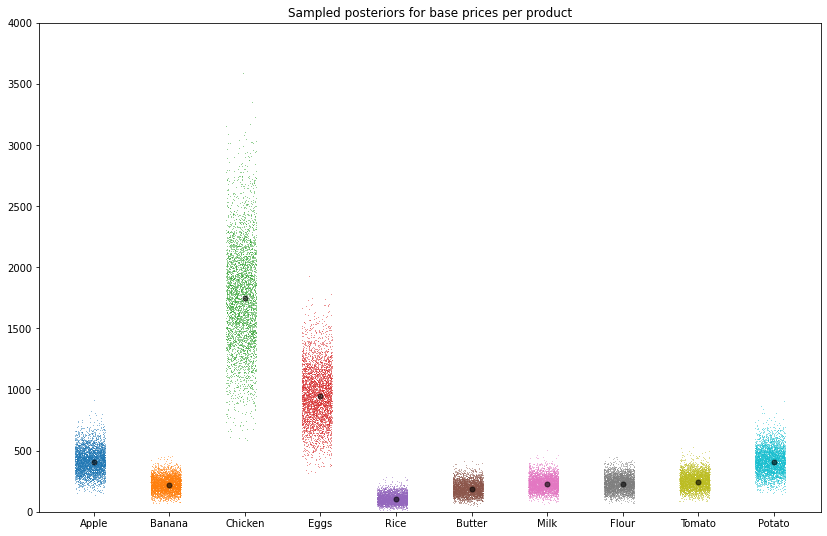

In [16]:
samples= results.extract()
base_price = samples['base_price']

plt.figure(figsize=(14, 9))

for i in range(10):
    plt.plot(sts.uniform.rvs(loc=i-0.25, scale=0.4, size=4000), base_price[:,i], ',', alpha=0.5)
plt.plot(range(10), base_price.mean(axis=0), marker = 'o', linewidth=0, markersize=5, alpha = 0.6, color='black')
plt.title('Sampled posteriors for base prices per product')
plt.xticks(range(len(product.unique())), ['Apple', 'Banana', 'Chicken', 'Eggs', 'Rice', 'Butter', 'Milk', 'Flour', 'Tomato', 'Potato'])
plt.ylim(0, 4000)
plt.show()

### Store Multiplier:

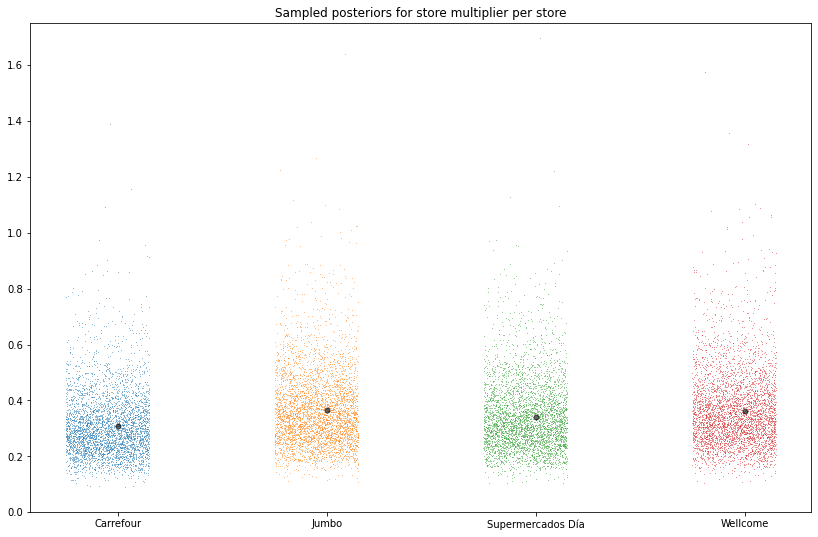

In [17]:
store_multiplier = samples['store_multiplier']

plt.figure(figsize=(14, 9))

for i in range(len(store.unique())):
    plt.plot(sts.uniform.rvs(loc=i-0.25, scale=0.4, size=4000), store_multiplier[:,i], ',', alpha=0.5)
plt.plot(range(4), store_multiplier.mean(axis=0), marker = 'o', linewidth=0, markersize=5, alpha = 0.6, color='black')
plt.title('Sampled posteriors for store multiplier per store')
plt.xticks(range(len(store.unique())), ['Carrefour', 'Jumbo', 'Supermercados Día', 'Wellcome'])
plt.ylim(0, 1.75)
plt.show()

### Neighborhood Multiplier:

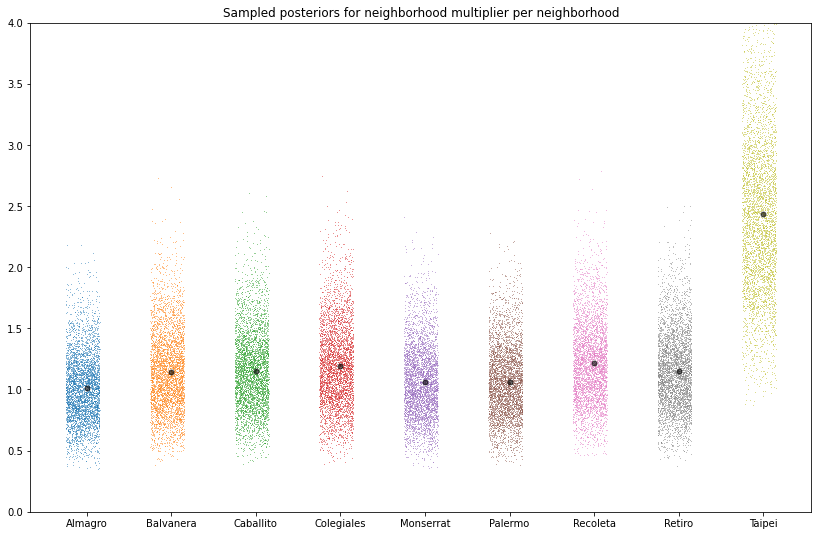

In [18]:
neighborhood_multiplier = samples['neighborhood_multiplier']

plt.figure(figsize=(14, 9))

for i in range(len(neighborhood.unique())):
    plt.plot(sts.uniform.rvs(loc=i-0.25, scale=0.4, size=4000), neighborhood_multiplier[:,i], ',', alpha=0.5)
plt.plot(range(9), neighborhood_multiplier.mean(axis=0), marker = 'o', linewidth=0, markersize=5, alpha = 0.6, color='black')
plt.title('Sampled posteriors for neighborhood multiplier per neighborhood')
plt.xticks(range(len(neighborhood.unique())), ['Almagro', 'Balvanera', 'Caballito', 'Colegiales', 'Monserrat', 'Palermo', 'Recoleta', 'Retiro', 'Taipei'])
plt.ylim(0, 4)
plt.show()

## **Comparison between rent and location multiplier**
Rent prices for BA recovered from (https://medium.com/@andavip/how-much-it-cost-to-rent-in-buenos-aires-mapped-by-its-metro-stations-62fbb7ae99e3). Rent price for comparable apartment in Taipei near city center recovered from (https://www.expatarrivals.com/asia-pacific/taiwan/taipei/cost-living-taipei)

I added the average price of the metro station closest to the middle of the neighborhood area, which might bias the analysis as it is not an average of all the stations in the neighborhood.

Additionally, rent prices for BA are relative to 2016, while rent prices for Taipei are relative to 2020. Thus, I use the exchange rate of 2016 to convert, assuming that prices have not changed significantly even though the exchange rate fluctuated.

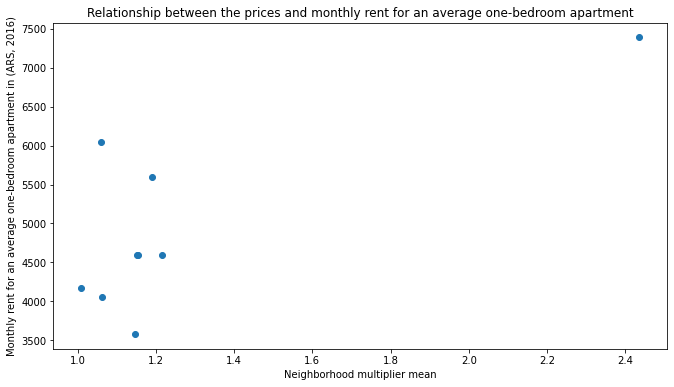

Correlation coefficient: 0.7677237394387018


In [19]:
rent = [4167, 3580, 4600, 5600, 4060, 6050, 4600, 4600, 7389.9]
neighborhood_multiplier_list = list(neighborhood_multiplier.mean(axis=0))

plt.figure(figsize=(11, 6))
plt.scatter(neighborhood_multiplier_list,rent)
plt.title('Relationship between the prices and monthly rent for an average one-bedroom apartment')
plt.xlabel("Neighborhood multiplier mean")
plt.ylabel("Monthly rent for an average one-bedroom apartment in (ARS, 2016)")
plt.show()

print ('Correlation coefficient: ' + str(sts.pearsonr(neighborhood_multiplier_list, rent)[0]))

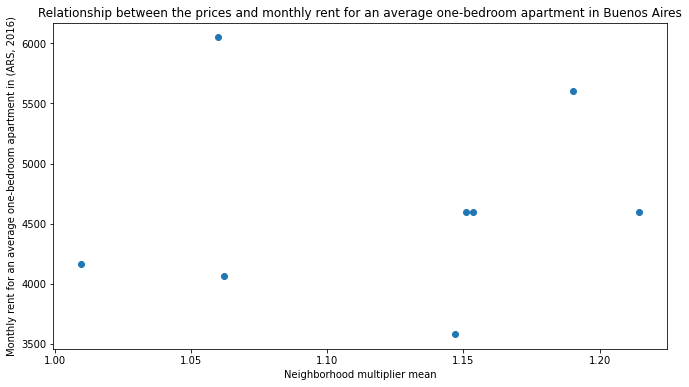

Correlation coefficient: 0.08116711851908716


In [20]:
# Excluding Taipei
rent_BA = [4167, 3580, 4600, 5600, 4060, 6050, 4600, 4600]
neighborhood_multiplier_list = list(neighborhood_multiplier.mean(axis=0))
del neighborhood_multiplier_list[8]

plt.figure(figsize=(11, 6))
plt.scatter(neighborhood_multiplier_list,rent_BA)
plt.title('Relationship between the prices and monthly rent for an average one-bedroom apartment in Buenos Aires')
plt.xlabel("Neighborhood multiplier mean")
plt.ylabel("Monthly rent for an average one-bedroom apartment in (ARS, 2016)")
plt.show()

print ('Correlation coefficient: ' + str(sts.pearsonr(neighborhood_multiplier_list, rent_BA)[0]))